In [2]:
!pip install langchain langchain-classic langchain-community langchain-huggingface langchain-unstructured unstructured unstructured-client "unstructured[html]" chromadb langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 46.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.6/219.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 79.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [15]:
!pip install google-search-results>=2.4.2

In [21]:
!pip install -U ddgs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 39.7 MB/s eta 0:00:00


In [16]:
from langgraph.graph import START , END , StateGraph
from langchain_huggingface import ChatHuggingFace , HuggingFaceEndpoint
from langgraph.prebuilt import ToolNode , tools_condition
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
from dotenv import load_dotenv
from typing import TypedDict , Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from langchain_classic.utilities.google_scholar import GoogleScholarAPIWrapper
import os
from google.colab import userdata
import requests
import re

In [ ]:
load_dotenv()

True

In [22]:

google_scholar_search = GoogleScholarAPIWrapper(
    serp_api_key = userdata.get('SERP_API_KEY'),
    google_scholar_engine= "google_scholar",
)

google_scholar_search.run("swapnil mishra iit ism ")

'Title: Factors affecting crack length of a shallow tunnel under surface impact load\nAuthors: S Mishra,A Mishra,KS Rao,NK Gupta\nSummary: S Mishra, A Mishra, KS Rao, NK Gupta - Indian Geotechnical Journal, 2025 - Springer\nTotal-Citations: 2\n\nTitle: An Experimental Approach to Analyze the Effect of Impact Loading on Shallow\nAuthors: S Mishra,A Kumar,KS Rao\nSummary: S Mishra, A Kumar, KS Rao… - Dynamic Behavior of Soft …, 2023 - books.google.com\nTotal-Citations: \n\nTitle: A detailed review study on utilization of mine and industrial wastes for backfill strengthening\nAuthors: AK Yadav,S Mishra,DP Mishra\nSummary: AK Yadav, S Mishra, DP Mishra - Arabian Journal of Geosciences, 2024 - Springer\nTotal-Citations: 12\n\nTitle: Numerical analysis of moving train induced vibrations on tunnel, surrounding ground and structure\nAuthors: S Srivastav,S Chawla,S Mishra\nSummary: S Srivastav, S Chawla, S Mishra - Earthquake Engineering and …, 2024 - Springer\nTotal-Citations: 11\n\nTitle: FEA

In [ ]:
llm = HuggingFaceEndpoint(
    repo_id='allenai/Olmo-3-7B-Instruct',
    huggingfacehub_api_token = os.environ["HF_TOKEN"],
)

model = ChatHuggingFace(llm=llm)


In [ ]:
model.invoke("who are you ?").content

"\nI am Olmo, an AI language model developed by Ai2 (Allen Institute for Artificial Intelligence). I'm here to assist you with information, answer questions, provide explanations, and help with a variety of tasks. If you have any specific questions or need help with something, feel free to ask!"

# create tools

In [ ]:
search_tool = DuckDuckGoSearchRun()

@tool
def google_scholar_search(name:str) -> dict:
  """
    Searches Google Scholar for a professor's publications, specifically targeting IIT ISM Dhanbad.

    This function cleans the input name, performs spelling correction to ensure accuracy,
    and appends university-specific keywords to narrow down the search results.

    Args:
        name (str): The name of the professor to search for.

    Returns:
        dict: A dictionary containing the cleaned professor name and the raw search
              results from Google Scholar.
  """

  name = name.lower()
  name = re.sub(r'\b(iit|ism|dhanbad)\b', '', name)
  name = ' '.join(name.split())

  google_scholar_search_tool = GoogleScholarAPIWrapper(
    serp_api_key = userdata.get('SERP_API_KEY'),
    google_scholar_engine= "google_scholar",
  )

  result = google_scholar_search_tool.run(f"{name} iit ism ")

  return {"Professor": name.title(), "results": result}


@tool
def calculator_tool(first_num:float , second_num:float , operation : str) -> dict :
    """
    Perform a basic arithmetic operation on two numbers.
    Supported operations: add, sub, mul, div
    """

    try:
        if operation == "add":
            result = first_num + second_num
        elif operation == "sub":
            result = first_num - second_num
        elif operation == "mul":
            result = first_num * second_num
        elif operation == "div":
            if second_num == 0:
                return {"error": "Division by zero is not allowed"}
            result = first_num / second_num
        else:
            return {"error": f"Unsupported operation '{operation}'"}

        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}


@tool
def get_stock_price(symbol : str) -> dict :
    """
    Fetch latest stock price for a given symbol (e.g. 'AAPL', 'TSLA')
    using Alpha Vantage with API key in the URL.
    """

    api_key = os.environ['STOCK_API_KEY']
    url = f"https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey={api_key}"
    r = requests.get(url)
    return r.json()


In [ ]:
get_stock_price("IBM")

{'Global Quote': {'01. symbol': 'IBM',
  '02. open': '301.0300',
  '03. high': '303.1800',
  '04. low': '298.3200',
  '05. price': '302.7900',
  '06. volume': '2612100',
  '07. latest trading day': '2025-12-22',
  '08. previous close': '300.9800',
  '09. change': '1.8100',
  '10. change percent': '0.6014%'}}

In [ ]:
tools = [search_tool , calculator_tool , get_stock_price]
model_with_tools = model.bind_tools(tools)

In [ ]:
model_with_tools.invoke("what is the current stock price of IBM?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"symbol": "IBM"}', 'name': 'get_stock_price', 'description': None}, 'id': 'chatcmpl-tool-90663c5b048360ca', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 381, 'total_tokens': 392}, 'model_name': 'allenai/Olmo-3-7B-Instruct', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019b6664-21bf-71a2-8f12-ac77c5340f84-0', tool_calls=[{'name': 'get_stock_price', 'args': {'symbol': 'IBM'}, 'id': 'chatcmpl-tool-90663c5b048360ca', 'type': 'tool_call'}], usage_metadata={'input_tokens': 381, 'output_tokens': 11, 'total_tokens': 392})

# create graph state

In [ ]:
class ChatState(TypedDict):
    messages : Annotated[list[BaseMessage] , add_messages]

# create nodes

In [ ]:
def chat_node(state : ChatState):

    ai_message = model_with_tools.invoke(state['messages'])
    return {"messages" : [ai_message]}

tool_node = ToolNode(tools)

# create graph

In [ ]:
graph = StateGraph(ChatState)

graph.add_node("chat_node" ,chat_node )
graph.add_node("tools" , tool_node)

graph.add_edge(START , "chat_node")
graph.add_conditional_edges("chat_node" , tools_condition)
graph.add_edge("tools" , "chat_node")

chatbot = graph.compile()

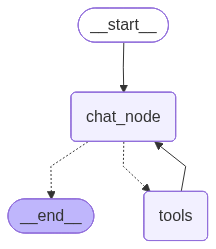

In [ ]:
chatbot

In [ ]:
output = chatbot.invoke({"messages" : "what is the currect stock price of apple and how much it cost to buy 50 shares ?"})
output["messages"][-1].content

'The current stock price of Apple (AAPL) is $273.40 per share. To buy 50 shares, the total cost would be approximately $13,670.00.'